In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Import min-max scaling function
from sklearn.preprocessing import MinMaxScaler

# Import keras lstm model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
df_store = pd.read_csv('//content/drive/MyDrive/INDONESIA.AI/DATASET/PROJECT 1/store5.csv')

In [ ]:
df_store.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
0,1452,2013-01-01,5,AUTOMOTIVE,0.0,0,NaN
1,1453,2013-01-01,5,BABY CARE,0.0,0,NaN
2,1454,2013-01-01,5,BEAUTY,0.0,0,NaN
3,1455,2013-01-01,5,BEVERAGES,0.0,0,NaN
4,1456,2013-01-01,5,BOOKS,0.0,0,NaN


In [ ]:
selected_families = ['AUTOMOTIVE', 'HOME APPLIANCES', 'SCHOOL AND OFFICE SUPPLIES', 'PRODUCE']
data= df_store[df_store['family'].isin(selected_families)].copy()
data

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
0,1452,2013-01-01,5,AUTOMOTIVE,0.000,0,NaN
17,1469,2013-01-01,5,HOME APPLIANCES,0.000,0,NaN
30,1482,2013-01-01,5,PRODUCE,0.000,0,NaN
31,1483,2013-01-01,5,SCHOOL AND OFFICE SUPPLIES,0.000,0,NaN
33,3234,2013-01-02,5,AUTOMOTIVE,6.000,0,93.14
...,...,...,...,...,...,...,...
55537,2998807,2017-08-14,5,SCHOOL AND OFFICE SUPPLIES,0.000,0,47.59
55539,3000558,2017-08-15,5,AUTOMOTIVE,9.000,0,47.57
55556,3000575,2017-08-15,5,HOME APPLIANCES,0.000,0,47.57
55569,3000588,2017-08-15,5,PRODUCE,1357.823,4,47.57


# DATA PREPARATION

In [ ]:
selected_families = ['AUTOMOTIVE']
data_automotive= df_store[df_store['family'].isin(selected_families)].copy()
data_automotive

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
0,1452,2013-01-01,5,AUTOMOTIVE,0.0,0,NaN
33,3234,2013-01-02,5,AUTOMOTIVE,6.0,0,93.14
66,5016,2013-01-03,5,AUTOMOTIVE,4.0,0,92.97
99,6798,2013-01-04,5,AUTOMOTIVE,6.0,0,93.12
132,8580,2013-01-05,5,AUTOMOTIVE,4.0,0,NaN
...,...,...,...,...,...,...,...
55407,2993430,2017-08-11,5,AUTOMOTIVE,12.0,0,48.81
55440,2995212,2017-08-12,5,AUTOMOTIVE,1.0,0,NaN
55473,2996994,2017-08-13,5,AUTOMOTIVE,15.0,0,NaN
55506,2998776,2017-08-14,5,AUTOMOTIVE,6.0,0,47.59


In [ ]:
plot_x = data_automotive['date'].copy()

In [ ]:
data_automotive['date'] = pd.to_datetime(data_automotive['date'])
data_automotive.set_index('date', inplace=True)

# Preprocessing

In [ ]:
drop = pd.DataFrame(data_automotive)

# Fitur yang ingin dihapus
features_to_drop = ['id', 'store_nbr', 'onpromotion', 'dcoilwtico']

# Menghapus fitur tersebut
df_automotive = drop.drop(columns=features_to_drop)


In [ ]:
df_automotive

,family,sales
date,,
2013-01-01,AUTOMOTIVE,0.0
2013-01-02,AUTOMOTIVE,6.0
2013-01-03,AUTOMOTIVE,4.0
2013-01-04,AUTOMOTIVE,6.0
2013-01-05,AUTOMOTIVE,4.0
...,...,...
2017-08-11,AUTOMOTIVE,12.0
2017-08-12,AUTOMOTIVE,1.0
2017-08-13,AUTOMOTIVE,15.0


In [ ]:
# Split data
# Scalling

scaler = MinMaxScaler()
#df_automotive.drop(['family'], axis=1, inplace=True)
x = df_automotive['sales'].copy()

x = scaler.fit_transform(x.values.reshape(-1, 1))

In [ ]:
def load_data(X, seq_len, train_size=0.8):
    amount_of_features = X.shape[1]
    sequence_length = seq_len + 1
    data = []

    for index in range(len(X) - sequence_length):
        data.append(X[index: index + sequence_length])

    data = np.array(data)
    train_split = int(round(train_size * data.shape[0]))
    train_data = data[:train_split, :]

    x_train = train_data[:, :-1]
    y_train = train_data[:, -1]

    x_test = data[train_split:, :-1]
    y_test = data[train_split:, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))

    return x_train, y_train, x_test, y_test

window = 22
X_train, y_train, X_test, y_test = load_data(x, window)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1329, 22, 1) (1329, 1) (332, 22, 1) (332, 1)


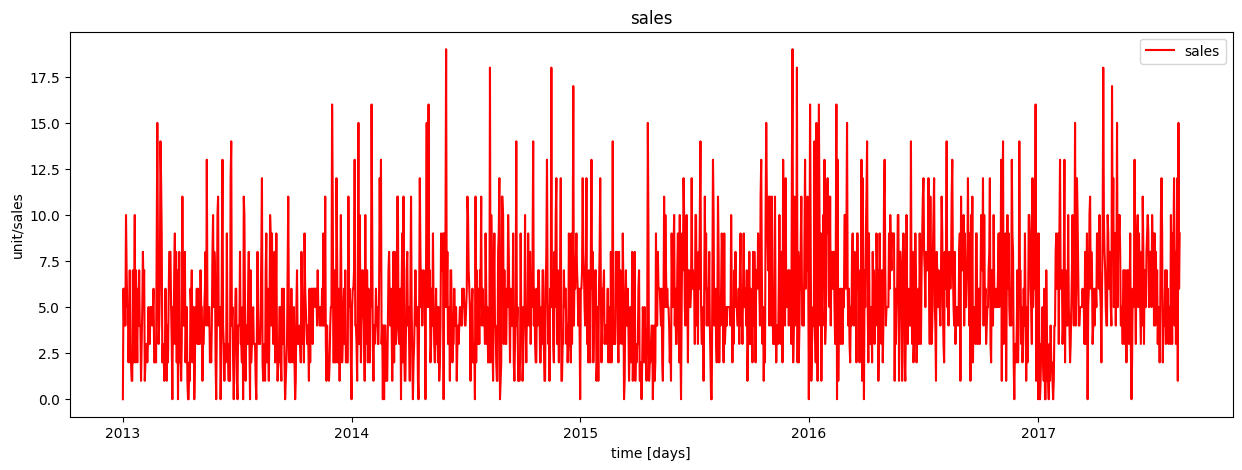

In [ ]:
plt.figure(figsize=(15, 5));
plt.plot(df_automotive['sales'], color='red', label='sales')

#plt.plot(df_stock_norm.volume.values, color='gray', label='volume')
plt.title('sales')
plt.xlabel('time [days]')
plt.ylabel('unit/sales')
plt.legend(loc='best')
plt.show()

In [ ]:
#LSTM architecture
model = Sequential()
# First LSTM layer with Dropout regularisation
model.add(LSTM(units=50, input_shape=(window,1)))
model.add(Dropout(0.2))
# The output layer
model.add(Dense(units=50, kernel_initializer='uniform', activation='tanh'))
model.add(Dense(units=1, kernel_initializer='uniform', activation='linear'))

earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
callbacks_list = [earlystop]

# Compiling the RNN
model.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
start = time.time()
LSTM=model.fit(X_train,y_train,epochs=100,batch_size=35, validation_split=0.05, verbose=1,callbacks=callbacks_list)
print ('compilation time : ', time.time() - start)

Epoch 1/100
37/37 [==============================] - 3s 16ms/step - loss: 0.0516 - val_loss: 0.0290
Epoch 2/100
37/37 [==============================] - 0s 5ms/step - loss: 0.0295 - val_loss: 0.0245
Epoch 3/100
37/37 [==============================] - 0s 6ms/step - loss: 0.0292 - val_loss: 0.0254
Epoch 4/100
37/37 [==============================] - 0s 5ms/step - loss: 0.0294 - val_loss: 0.0274
Epoch 5/100
37/37 [==============================] - 0s 5ms/step - loss: 0.0290 - val_loss: 0.0243
Epoch 6/100
37/37 [==============================] - 0s 8ms/step - loss: 0.0293 - val_loss: 0.0256
Epoch 7/100
37/37 [==============================] - 0s 8ms/step - loss: 0.0296 - val_loss: 0.0247
Epoch 8/100
37/37 [==============================] - 0s 7ms/step - loss: 0.0291 - val_loss: 0.0275
Epoch 9/100
37/37 [==============================] - 0s 8ms/step - loss: 0.0293 - val_loss: 0.0242
Epoch 10/100
37/37 [==============================] - 0s 7ms/step - loss: 0.0288 - val_loss: 0.0241
Epoch 11

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 50)                10400     
                                                                 
 dropout_8 (Dropout)         (None, 50)                0         
                                                                 
 dense_8 (Dense)             (None, 50)                2550      
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                                 
Total params: 13001 (50.79 KB)
Trainable params: 13001 (50.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<Axes: >

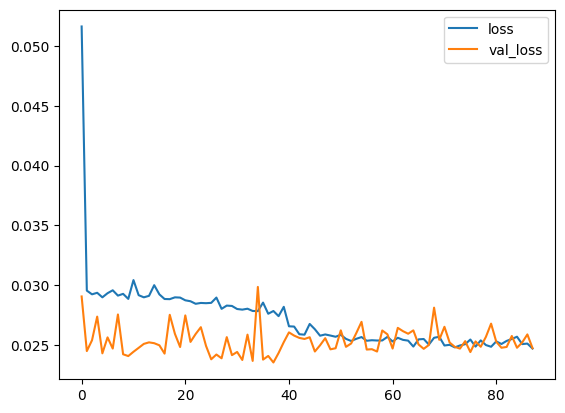

In [ ]:
%matplotlib inline
losses = pd.DataFrame(LSTM.history)
losses.plot()

MODEL PREDICT

In [ ]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(y_train)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(y_test)

11/11 [==============================] - 0s 2ms/step


In [ ]:
testPredict.shape

(332, 1)

In [ ]:
plot_predicted = testPredict.copy()
plot_predicted = plot_predicted.reshape(332, 1)
plot_actual = testY.copy()
plot_actual = plot_actual.reshape(332, 1)
print(plot_actual.shape)
print(plot_predicted.shape)

(332, 1)
(332, 1)


In [ ]:
df_automotive

,family,sales
date,,
2013-01-01,AUTOMOTIVE,0.0
2013-01-02,AUTOMOTIVE,6.0
2013-01-03,AUTOMOTIVE,4.0
2013-01-04,AUTOMOTIVE,6.0
2013-01-05,AUTOMOTIVE,4.0
...,...,...
2017-08-11,AUTOMOTIVE,12.0
2017-08-12,AUTOMOTIVE,1.0
2017-08-13,AUTOMOTIVE,15.0


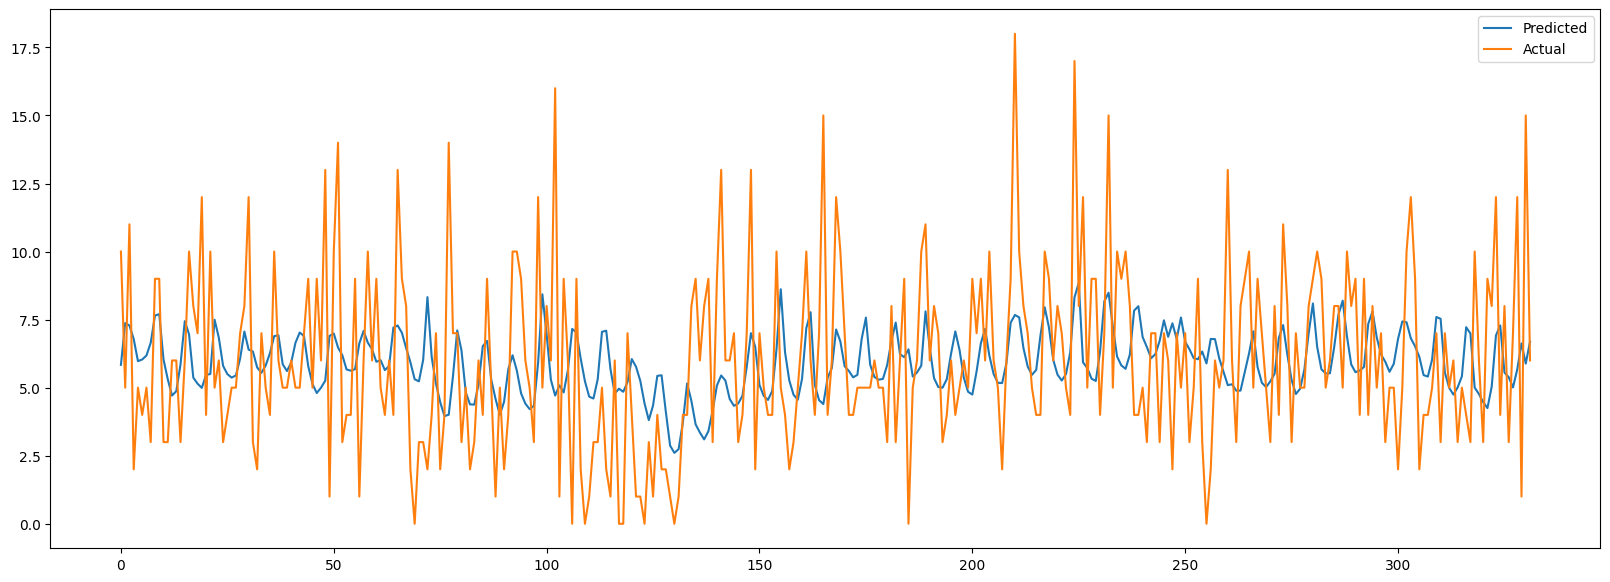

In [ ]:
plt.figure(figsize=(20,7))
plot_x = pd.to_datetime(plot_x.iloc[-332:])
plt.plot(pd.DataFrame(plot_predicted), label='Predicted')
plt.plot(pd.DataFrame(plot_actual), label='Actual')
plt.legend(loc='best')
plt.show()

In [ ]:
trainY.shape

(1329, 1)

In [ ]:
trainPredict.shape

(1329, 1)

In [ ]:
trainScore = mean_squared_error(trainY, trainPredict) ** .5
print('Train Score: %.2f RMSE' % (trainScore))
testScore = mean_squared_error(testY, testPredict) ** .5
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.98 RMSE
Test Score: 3.22 RMSE


In [ ]:
automotive_sales = df_automotive.sales.values.astype('float32')
automotive_sales = automotive_sales.reshape(len(automotive_sales), 1)

In [ ]:
trainPredictPlot = np.empty_like(automotive_sales)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[22:len(trainPredict)+22, :] = trainPredict

testPredictPlot = np.empty_like(automotive_sales)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(automotive_sales) - testPredict.shape[0]):len(automotive_sales), :] = testPredict

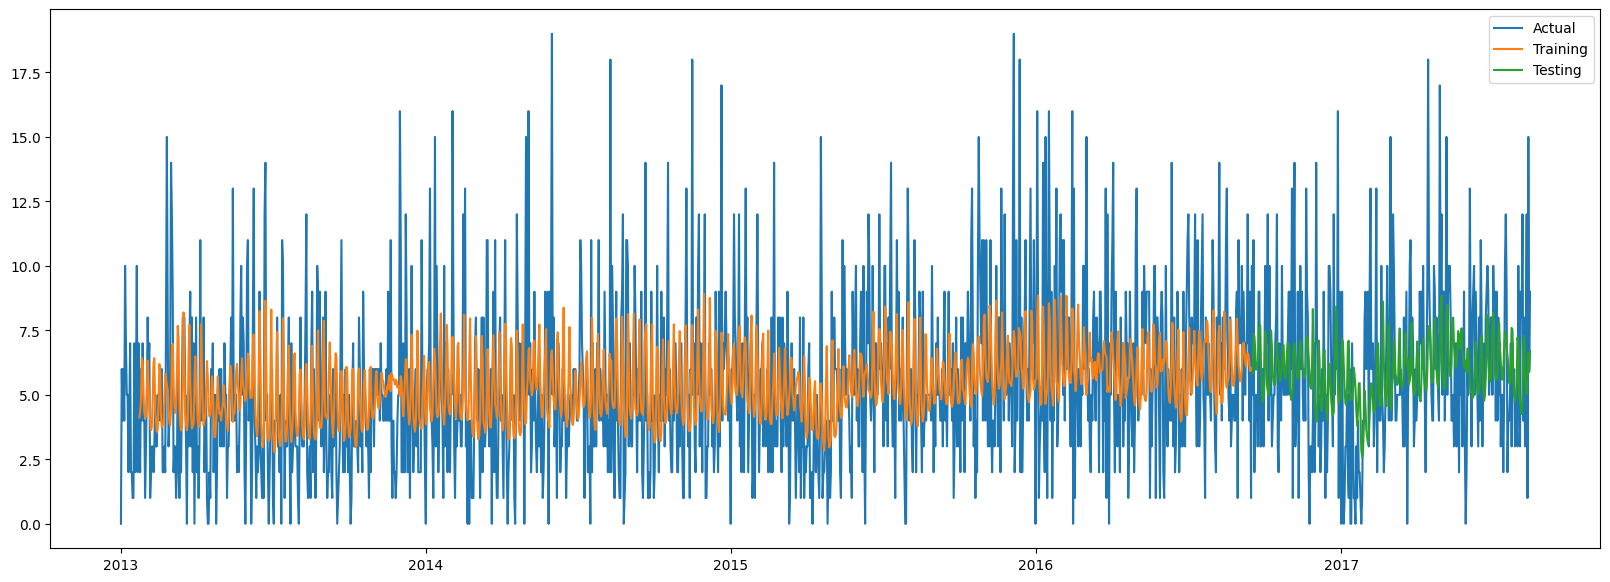

In [ ]:
plt.figure(figsize=(20,7))
plt.plot(pd.DataFrame(automotive_sales, columns=["sales"], index=df_automotive.index).sales, label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns=["sales"], index=df_automotive.index).sales, label='Training')
plt.plot(pd.DataFrame(testPredictPlot, columns=["sales"], index=df_automotive.index).sales, label='Testing')
plt.legend(loc='best')
plt.show()